Airbnb has disrupted the traditional hospitality industry as more and more travellers decide to use Airbnb as their primary accomodation provider.
  In the United Kingdom, no city is more popular than London. This implies that London is one of the hottest markets for Airbnb in Europe with over 80,000 listings as of 2019. With an average size of over 1000 sq.km, this means that there are approximateley 25 homes being rented out per sq.km in London on Airbnb.


> In this notebook we will be trying to determine a fairly spot on daily price for a new accomodation that fits into it's specific market environment and competitors in London. Thus, having this objective allows us to focus on the accomodation features and decisions that a new host can make with regards to the initial presentation that involves posting a picture of him/her-self on the website, determining a minimum leght of stay, offering instant bookings etc. 


> To address these objectives we will be building a machine learning model using XGBOOST. But before we can proceed to model building we will be performing modules that involves feature engineering and Exploratory Data Analysis in order to understand what exactly is present in our dataset and what can we begin to interpret form the data through analysis and visualizations





For this program we will be using Google Colab as the development environment with the runtime being the GPU and the RAM set to 12GB. The dataset was acquired from http://data.insideairbnb.com/united-kingdom/england/london/2019-07-10/data/listings.csv.gz . The data was drawn from the website Inside Airbnb and the dataset compressed folder that was downloaded was named as listings.csv.gz. The first step involved uploading this zipped folder into Google Colab and the code for that is in the cell below. 

In [0]:
from google.colab import files
data = files.upload()

Saving listings.csv.gz to listings.csv.gz


In [0]:
#Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import re
import xgboost as xgb
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

In [0]:
#Importing the dataset and converting the dataset into a dataframe
listings_file_name = 'listings.csv.gz'
listings = pd.read_csv(listings_file_name, compression = "gzip", low_memory = False)
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [0]:
#Checking the shape of the dataset
print("The dataset has {} rows and {} columns.".format(*listings.shape))

# ... and the duplicates
print("It contains {} duplicates.".format(listings.duplicated().sum()))

The dataset has 83850 rows and 106 columns.
It contains 0 duplicates.


In [0]:
#Printing all the columns in the dataset
for i in listings.columns:
  print(i, sep = ',')

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_ni

**PRE-PROCESSING THE DATA**

*Deciding which columns to keep and work with*
Suppose we wish to list our property over to the website. The fixed features of our property include its rooms, size and location. We can also decide as to how it is to be listed i.e with a picture or not, how many minimum nights we want a guest to stay and whther we are instantly bookable, how we handle cancellations etc. But the columns that are cuurently out of scope for us being a new property is that we do not have nay reviews to show yet which can be somtimes important if we wish to set a price.
  But for now we will focus on the features that we can control and work with them. Thus, these features are compiled into a list and the rest are removed from further processing.

In [0]:
#Defining the colums to keep
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_new = listings[columns_to_keep].set_index('id')
print("the dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_new.shape))

the dataset has 83850 rows and 23 columns - after dropping irrelevant columns.


Identifying how many room types we have in our dataset.

In [0]:
df_new.room_type.value_counts(normalize=True)

Entire home/apt    0.562218
Private room       0.429004
Shared room        0.008778
Name: room_type, dtype: float64

Also identifying how many property types we are up against.

In [0]:
df_new.property_type.value_counts(normalize=True)

Apartment                 0.677424
House                     0.207943
Townhouse                 0.035528
Serviced apartment        0.022612
Condominium               0.013202
Bed and breakfast         0.010459
Loft                      0.008527
Guest suite               0.004246
Guesthouse                0.003327
Hostel                    0.002755
Boutique hotel            0.002648
Other                     0.002457
Hotel                     0.001801
Bungalow                  0.001574
Cottage                   0.000990
Villa                     0.000751
Boat                      0.000680
Aparthotel                0.000644
Tiny house                0.000513
Houseboat                 0.000358
Cabin                     0.000286
Casa particular (Cuba)    0.000250
Camper/RV                 0.000203
Barn                      0.000143
Chalet                    0.000143
Earth house               0.000119
Hut                       0.000107
Yurt                      0.000048
Farm stay           

*Cleaning the price columns*

In [0]:
df_new[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
13913,$65.00,$15.00,$15.00,$100.00
15400,$100.00,$50.00,$0.00,$150.00
17402,$300.00,$65.00,$10.00,$350.00


Checking is there are any null values in the price column 

In [0]:
# checking Nan's in "price" column
df_new.price.isna().sum()

0

So since there are no null values we don't need to drop any rows. Similarly,  we will now check the same for the 'cleaning_fee'.

In [0]:
# Nan's in "cleaning_fee" column
df_new.cleaning_fee.isna().sum()

21572

As we can see there are quite a lot of null values and we can infer that there are plenty of Nan's and thus it means that the hosts probably do not charge any extra cleaning fee. So we will be replacing these values with '$0.00'

In [0]:
df_new.cleaning_fee.fillna('$0.00', inplace=True)
df_new.cleaning_fee.isna().sum()

0

In [0]:
df_new.security_deposit.isna().sum()

29475

Similarly with the security deposit we will be performing the same operation as done on cleaning_fee

In [0]:
df_new.security_deposit.fillna('$0.00', inplace=True)
df_new.security_deposit.isna().sum()

0

In [0]:
df_new.extra_people.isna().sum()

0

Now we can proceed with removing the dollar signs in all four columns and convert the string values into numerical values.

In [0]:
# clean up the columns (by method chaining)
df_new.price = df_new.price.str.replace('$', '').str.replace(',', '').astype(float)
df_new.cleaning_fee = df_new.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_new.security_deposit = df_new.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_new.extra_people = df_new.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

In [0]:
df_new['price'].describe() #Investigating the price column to determine if further cleaning is required.

count    83850.000000
mean       121.656303
std        224.900151
min          0.000000
25%         45.000000
50%         81.000000
75%        140.000000
max      13700.000000
Name: price, dtype: float64

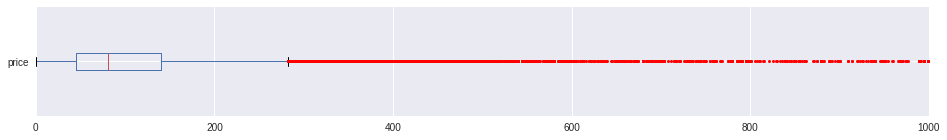

In [0]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_new['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

From the 'price' column description we can see that 75% of the places are charging 140 pounds and the maximum price that is present is 13700 pounds. From the boxplot we can see that the outliers start to show themselves after the 400 pounds mark and then seem to 'fringe' and sometimes drop records that charge more than that. Also we have records where the prices are set to zero. So for modification we will be setting a limit of 400 pounds and dropping records where the prices are zero. 

In [0]:
df_new.drop(df_new[ (df_new.price > 400) | (df_new.price == 0) ].index, axis=0, inplace=True)

In [0]:
df_new['price'].describe()

count    81325.000000
mean        99.839852
std         73.207791
min          6.000000
25%         45.000000
50%         80.000000
75%        130.000000
max        400.000000
Name: price, dtype: float64

In [0]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df_new.shape))

The dataset has 81325 rows and 23 columns - after being price-wise preprocessed.


*Dealing with Missing Values*

In [0]:
df_new.isna().sum()

space                           24679
description                      1741
host_has_profile_pic               47
neighbourhood_group_cleansed    81325
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                         136
bedrooms                           32
bed_type                            0
amenities                           0
square_feet                     80893
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

In [0]:
# drop columns with too many Nan's
df_new.drop(columns=['square_feet', 'space'], inplace=True)

In [0]:
# drop rows with NaN's in bathrooms and bedrooms
df_new.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

In [0]:
df_new.host_has_profile_pic.unique()

array(['t', 'f', nan], dtype=object)

In [0]:
# replace host_has_profile_pic Nan's with no
df_new.host_has_profile_pic.fillna(value='f', inplace=True)
df_new.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [0]:
df_new.isna().sum()

description                      1741
host_has_profile_pic                0
neighbourhood_group_cleansed    81157
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
bed_type                            0
amenities                           0
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

In [0]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_new.shape))

The dataset has 81157 rows and 21 columns - after having dealt with missing values.


We will now install geopy for using geocoding web services that will help us to locate places based on the corrdinates of the respective values given.

In [0]:
!pip install geopy

**Feature Enginnering-1: Distance to the Centroid of London**

The location is always an important factor in lodging services. I have decide to calculate each accomodation's distance to the so called centroid of London instead of just relying on the neighbourhood of areas.
  We will now develop and apply a function that does this and apply to each accomodation and store the values in a new column.

In [0]:
from geopy.distance import great_circle

In [0]:
def distance_to_mid(lat, lon):
    london_centre = (51.5074, 0.1277)
    accommodation = (lat, lon)
    return great_circle(london_centre, accommodation).km

In [0]:
df_new['distance'] = df_new.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [0]:
df_new.head(2)

,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,amenities,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,distance
id,,,,,,,,,,,,,,,,,,,,,,
13913,My bright double bedroom with a large window h...,t,NaN,51.56802,-0.11121,Apartment,Private room,2,1.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",65.0,15.0,100.0,15.0,1,1,f,f,moderate,17.845779
15400,Lots of windows and light. St Luke's Gardens ...,t,NaN,51.48796,-0.16898,Apartment,Entire home/apt,2,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",100.0,50.0,150.0,0.0,2,3,f,f,strict_14_with_grace_period,20.650835


**Feature Engineering-2: Lodging Size**

One of the most important pieces of information for predicting the rate is the size. Since the column square_feet was heavily filled with null values, I have dropped it in the previous section. 
Let us now check, if the column description reveals any information about size instead:


In [0]:
df_new.description.isna().sum()

1741

The description column seems to be rich in content. Let's extract:
 

*  all double-digit or three-digit numbers 
* that are followed by one of the two characters "s" or "m" (covering "sqm", "square meters", "m2" etc.) and
*   may or may not be connected by white space. 

Single- or more than three-digit numbers for accommodation sizes are quite unlikely.

In [0]:
#Extracting size from the text
# extract numbers 
df_new['size'] = df_new['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_new['size'] = df_new['size'].str.replace("\D", "")

# change datatype of size into float
df_new['size'] = df_new['size'].astype(float)

print('NaNs in size_column absolute:     ', df_new['size'].isna().sum())
print('NaNs in size_column in percentage:', round(df_new['size'].isna().sum()/len(df_new),3), '%')

NaNs in size_column absolute:      44800
NaNs in size_column in percentage: 0.552 %


In [0]:
df_new[['description', 'size']].head(10)

,description,size
id,,
13913,My bright double bedroom with a large window h...,NaN
15400,Lots of windows and light. St Luke's Gardens ...,NaN
17402,"Open from June 2018 after a 3-year break, we a...",NaN
24328,"Artist house, bright high ceiling rooms, priva...",NaN
25023,"Large, all comforts, 2-bed flat; first floor; ...",10.0
25123,Big room with double bed/ clean sheets/ clean ...,15.0
26223,Contemporary design meets classic London in th...,NaN
26482,Contemporary design meets classic London in th...,NaN
31361,"The name says it all, it really is a restful r...",NaN


In [0]:
# drop description column
df_new.drop(['description'], axis=1, inplace=True)

*Predicting missing values with regression*

As calculated further up, half of our records still don't have a size. Dropping these records isn't an option as we would loose too much valuable information. Simply replacing it with the mean or median makes no sense. So I have decide to predict the missing value with a Machine Learning Algorithm. In this algorithm, we'll only use numerical features. Next, we have to split our data into
*   a training set where we have sizes and
*   a test set where we don't.



In [0]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81157 entries, 13913 to 36585818
Data columns (total 22 columns):
host_has_profile_pic            81157 non-null object
neighbourhood_group_cleansed    0 non-null float64
latitude                        81157 non-null float64
longitude                       81157 non-null float64
property_type                   81157 non-null object
room_type                       81157 non-null object
accommodates                    81157 non-null int64
bathrooms                       81157 non-null float64
bedrooms                        81157 non-null float64
bed_type                        81157 non-null object
amenities                       81157 non-null object
price                           81157 non-null float64
cleaning_fee                    81157 non-null float64
security_deposit                81157 non-null float64
extra_people                    81157 non-null float64
guests_included                 81157 non-null int64
minimum_nights   

In [0]:
# filter out sub_df to work with
sub_df = df_new[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

In [0]:
# split datasets
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [0]:
print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (36357, 10)
Shape of Test Data:     (44800, 10)

Shape of X_train: (36357, 9)
Shape of X_test: (44800, 9)

Shape of y_train: (36357,)


In [0]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# making predictions
y_test = linreg.predict(X_test)

Now that we have predicted the missing sizes, let's cast y_test into a dataframe with a column size.

In [0]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

(44800, 1)


,size
0,39.921577
1,46.551715
2,88.899821
3,66.984293
4,56.311033


In [0]:
print(X_test.shape)
X_test.head()

(44800, 9)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance
id,,,,,,,,,
13913,2,1.0,1.0,65.0,15.0,100.0,15.0,1,17.845779
15400,2,1.0,1.0,100.0,50.0,150.0,0.0,2,20.650835
17402,6,2.0,3.0,300.0,65.0,350.0,10.0,4,18.587388
24328,2,1.5,1.0,175.0,70.0,250.0,0.0,2,20.539104
26223,4,1.0,1.0,147.0,75.0,100.0,15.0,3,16.346862


Now we have to combine our y_test and X_test back into our full test dataframe, but before we do so we can observe from the table that the x_test dataframe has a specific index thats not compatible with y_test, where the numbers simply start from 0 onwards. Thus we will now provide y_test with the X_test index to make sure everything fits togehter. 

In [0]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)
y_test.head()

,size
prelim,
13913,39.921577
15400,46.551715
17402,88.899821
24328,66.984293
26223,56.311033


In [0]:
new_test_data = pd.concat([X_test, y_test], axis=1)

In [0]:
print(new_test_data.shape)
new_test_data.head()

(44800, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
13913,2,1.0,1.0,65.0,15.0,100.0,15.0,1,17.845779,39.921577
15400,2,1.0,1.0,100.0,50.0,150.0,0.0,2,20.650835,46.551715
17402,6,2.0,3.0,300.0,65.0,350.0,10.0,4,18.587388,88.899821
24328,2,1.5,1.0,175.0,70.0,250.0,0.0,2,20.539104,66.984293
26223,4,1.0,1.0,147.0,75.0,100.0,15.0,3,16.346862,56.311033


In [0]:
new_test_data['size'].isna().sum()

0

Now that we have completed our new train_data, we stack test_data and train_data back to a new sub_dataframe across the rows.

In [0]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head()

(81157, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
13913,2,1.0,1.0,65.0,15.0,100.0,15.0,1,17.845779,39.921577
15400,2,1.0,1.0,100.0,50.0,150.0,0.0,2,20.650835,46.551715
17402,6,2.0,3.0,300.0,65.0,350.0,10.0,4,18.587388,88.899821
24328,2,1.5,1.0,175.0,70.0,250.0,0.0,2,20.539104,66.984293
26223,4,1.0,1.0,147.0,75.0,100.0,15.0,3,16.346862,56.311033


In [0]:
sub_df_new['size'].isna().sum()

0

Now we can proceed to the last step of this module i.e the merging of our sub_dataframe with the remaining columns from our original dataframe but this time across the columns.

In [0]:
# prepare the multiple columns before concatening
df_new.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

In [0]:
# concate back to complete dataframe
df = pd.concat([sub_df_new, df_new], axis=1)

print(df.shape)
df.head(2)

(81157, 22)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
13913,2,1.0,1.0,65.0,15.0,100.0,15.0,1,17.845779,39.921577,t,NaN,51.56802,-0.11121,Apartment,Private room,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",1,f,f,moderate
15400,2,1.0,1.0,100.0,50.0,150.0,0.0,2,20.650835,46.551715,t,NaN,51.48796,-0.16898,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",3,f,f,strict_14_with_grace_period


In [0]:
df['size'].isna().sum() #investigating the size column. 

0

In [0]:
df['size'].describe()

count    81157.000000
mean        44.727747
std         85.956595
min         -4.509688
25%         15.000000
50%         31.954270
75%         46.335470
max        995.000000
Name: size, dtype: float64

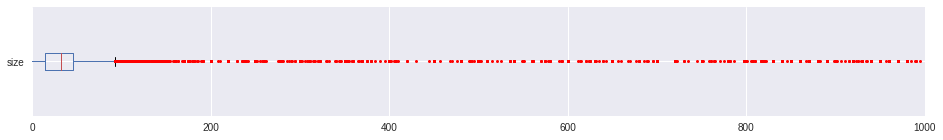

In [0]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

Based on the box plot we will remove all outliers over 300 square meters and all those with 0.

In [0]:
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

In [0]:
print("The dataset has {} rows and {} columns - after being engineered.".format(*df.shape))

The dataset has 79829 rows and 22 columns - after being engineered.


**Feature Engineering-3: Lodging Amenities**

The next point of interest was regarding what amenities hosts offer their guests and in irder to enrich our prediction, as to whther or not we can determine certain special/rare amenities that might make a property more desirable. 

In [0]:
from collections import Counter

In [0]:
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Wifi', 76765),
 ('Heating', 74893),
 ('Essentials', 74222),
 ('Kitchen', 73000),
 ('Smoke detector', 68224),
 ('Washer', 67936),
 ('Hangers', 63065),
 ('Iron', 59989),
 ('Hair dryer', 55029),
 ('TV', 54452),
 ('Shampoo', 54197),
 ('Laptop friendly workspace', 49846),
 ('Carbon monoxide detector', 45746),
 ('Hot water', 41183),
 ('Dryer', 35011),
 ('Refrigerator', 26900),
 ('Bed linens', 25824),
 ('Oven', 25054),
 ('First aid kit', 24598),
 ('Family/kid friendly', 24595),
 ('Fire extinguisher', 24544),
 ('Dishes and silverware', 24001),
 ('Microwave', 22744),
 ('Cooking basics', 22684),
 ('Stove', 21853),
 ('Internet', 19812),
 ('Lock on bedroom door', 18595),
 ('Elevator', 18057),
 ('Private entrance', 17212),
 ('Long term stays allowed', 16476)]

In [0]:
# create a new dataframe
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

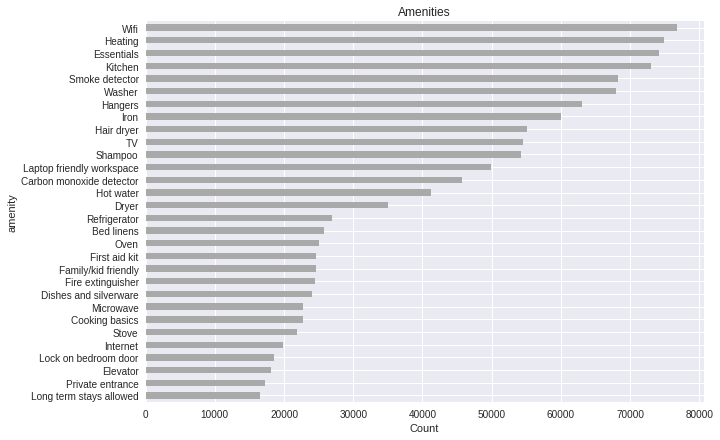

In [0]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

Lets add columns with amenities that are somewhat unique and not offered by all hosts. They are as follows:

*    laptop-friendly workspace
*   TV
*   kid friendly accommodation
*   smoker friendly and
*   being greeted by the host.

After doing this lets drop the orginal column.










In [0]:
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')

In [0]:
df.drop(['amenities'], axis=1, inplace=True)

**EXPLORATORY DATA ANALYSIS (EDA)**

*Price Differences on a Map*

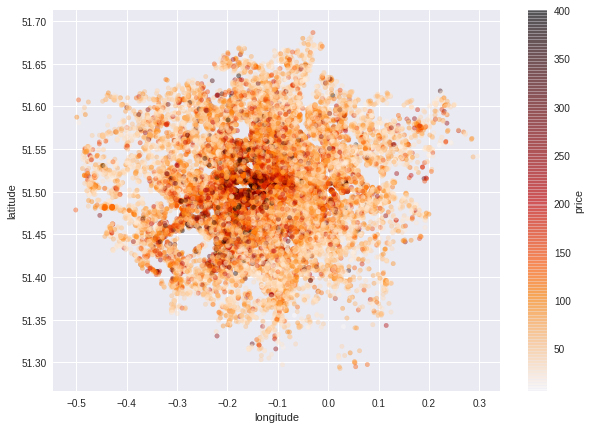

In [0]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

*Price Differences by Accommodation Distance to Center of London*

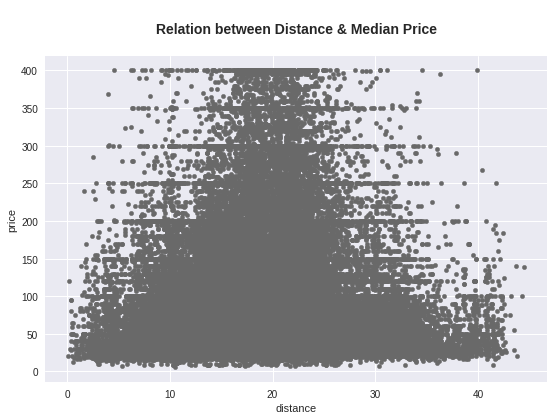

In [0]:
df.plot.scatter(x="distance", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

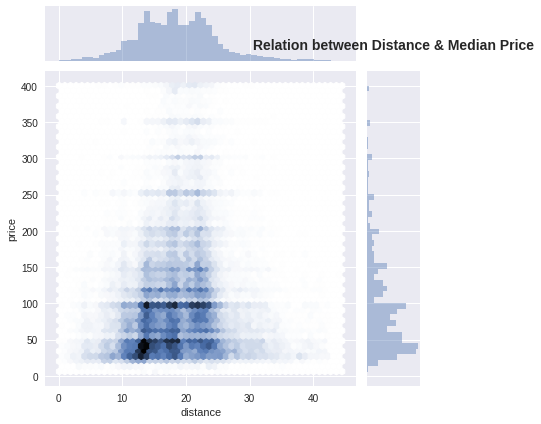

In [0]:
sns.jointplot(x=df["distance"], y=df["price"], kind='hex')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

*Price Differences by Accommodation Size*

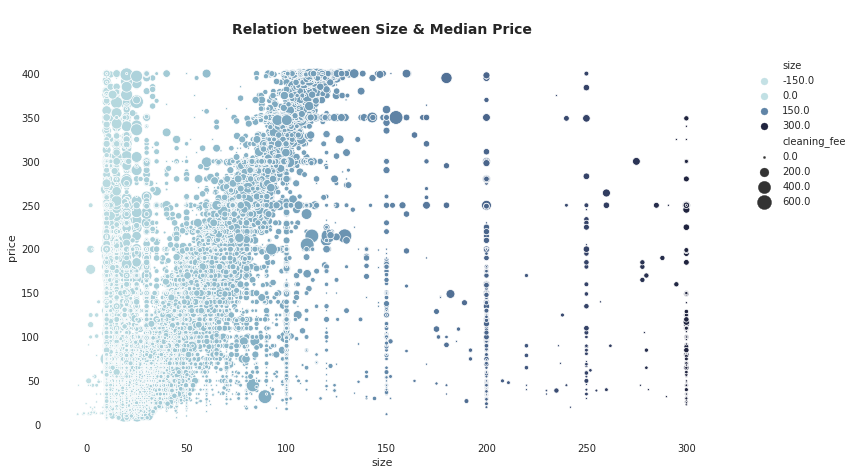

In [0]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size & Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

*Price Differences by Cancellation Policy*

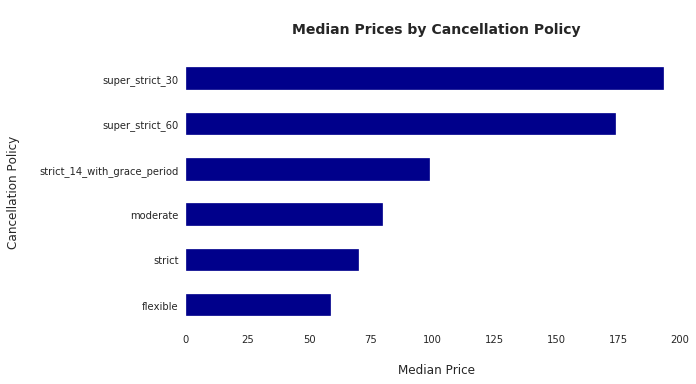

In [0]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');

**MODELLING THE DATA**

*Preparing the target and features*

In [0]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'distance',
       'size', 'host_has_profile_pic', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'bed_type',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready',
       'cancellation_policy', 'Laptop_friendly_workspace', 'TV',
       'Family_kid_friendly', 'Host_greets_you', 'Smoking_allowed'],
      dtype='object')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79829 entries, 13913 to 36585818
Data columns (total 26 columns):
accommodates                    79829 non-null int64
bathrooms                       79829 non-null float64
bedrooms                        79829 non-null float64
price                           79829 non-null float64
cleaning_fee                    79829 non-null float64
security_deposit                79829 non-null float64
extra_people                    79829 non-null float64
guests_included                 79829 non-null int64
distance                        79829 non-null float64
size                            79829 non-null float64
host_has_profile_pic            79829 non-null object
neighbourhood_group_cleansed    0 non-null float64
latitude                        79829 non-null float64
longitude                       79829 non-null float64
property_type                   79829 non-null object
room_type                       79829 non-null object
bed_type       

As we are working with the distance to the center we will now be dropping the neighnourhood_group_cleansed column along with property_types.

In [0]:
df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type'], axis=1, inplace=True)

Now we can convert all string columns into categorical ones.

In [0]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')

In [0]:
# define our target
target = df[["price"]]

# define our features 
features = df.drop(["price"], axis=1)

*Recoding Categorical Features*

Machine Learning Algorithms generally need data - including categorical data in numeric form. Thus now we have converted all the categorical features into separate binary features called dummy variables. So now, we will be applying one-hot encoding, which creates a new column for each unique category in a categorical variable. So now each observation receives a 1 in the column and 0 in all other new columns. To conduct one-hot encoding , we use the pandas get_dummies function.

In [0]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [0]:

features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [0]:
print(features_recoded.shape)
features_recoded.head(2)

(79829, 34)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed,host_has_profile_pic_f,host_has_profile_pic_t,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
13913,2,1.0,1.0,15.0,100.0,15.0,1,17.845779,39.921577,1,True,True,True,True,True,0,1,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0
15400,2,1.0,1.0,50.0,150.0,0.0,2,20.650835,46.551715,3,True,True,False,False,False,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0


*Splitting and Scaling the data*

In [0]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# split our data
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

Now we will be scaling our dataset so that the challenge of mixing features that have different scales are not present in our data. For example in our dataset, when we mix units with ranges that have different orders of magnitude, our model amy not be able to provide the proper coefficients. Thus, we standardize/normalize the features. 

In [0]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

*Training an XGBoost Regressor*

In [0]:
# create a baseline
booster = xgb.XGBRegressor()

In [0]:
#Tuning of hyperparameters fro the XGBoost model
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

[10:10:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [0]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

[10:13:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 26.9654


In [0]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.8642


*Cross-Validation*

IN order to build more robust models, it is common to conduct a k-fold cross validation where all the entries in the original training dataset are used for both training and validation. XGBoost supports k-fold cross validation via the cv method. All we have to do is specify the nfolds parameter, which is the number of cross validation rounds you want to build.
  But we will have to first convert the dataset into an optimized data structure called DMatrix so that XGBoost's cross validation method is supported.

In [0]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [0]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':6}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [0]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,117.481082,0.070254,117.492210,0.158291
1,112.165774,0.067155,112.181117,0.182693
2,107.424385,0.218003,107.451258,0.214854
3,102.793513,0.054204,102.831899,0.199989
4,98.539264,0.232990,98.589500,0.196840


In [0]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
195,25.745359,0.152934,28.386364,0.321009
196,25.724440,0.151874,28.378043,0.320106
197,25.710206,0.156382,28.370626,0.316484
198,25.694385,0.154399,28.364599,0.319569
199,25.686261,0.152389,28.365187,0.318371


**Interpreting the Data**

We can see that our average error (RMSE) in the initial XGBoost is around 2 pounds which improves to around 22P by cross-validation.

So we can infer that the price is dependant not only on the goegraphy, size and features but also on the following:
* The quality of the presentation (e.g. pictures)
* availability
* the number and content of reviews
* communication (e.g. acceptance rate, host response time) or
* status (whether or not the host is a super-host)

might have substantial influence too. But the purpose of this analysis was to recommend a price to a new lister without any reviews or status. With this in mind, we might say that we can't recommend an exact price but rather a price range as mentioned previously in the tables above.


The below plot highlights to a new user exactly what are the features that account for the over 70% variance with the most important accomodation features in pictorial format along with their respective weightage.

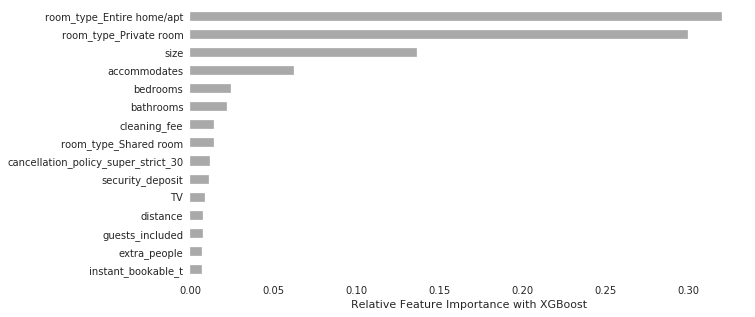

In [0]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');